## Task 1

Divide the given dataset on training and testing sets (try at least three different ratios), then 
tune the model parameters $\lambda_{pj}, \tau_{pj}, \tau_{j}, \lambda_{j}$ (using existing optimization packages or your own 
optimization  scheme)  on  the  training  set  and  make  forecasts  for  the  testing  set.  Plot  the 
results. 

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_excel('data.xlsx')
data.drop(index=0, inplace=True)
train_size = [0.6, 0.7, 0.8]

In [3]:
train_1, test_1 = train_test_split(data, train_size=train_size[0], shuffle=False)
train_2, test_2 = train_test_split(data, train_size=train_size[1], shuffle=False)
train_3, test_3 = train_test_split(data, train_size=train_size[2], shuffle=False)

$$ \hat{q}_{j}(t_{n}) = \lambda_{pj} q_{j}(t_0) e^{-\frac{t_n - t_0}{\tau_{pj}}} + \sum_{i=1}^{I} \lambda_{ij} \sum_{m=0}^{n} \bigg( 1 - e^{-\frac{\Delta t_m}{\tau_j}} \bigg) e^{-\frac{t_n - t_m}{\tau_j}} i_i(t_m), j=1,..,P $$


In [144]:
def CRMP_altogether(x, params):   
    lambda_pj = params[:4]
    tau_pj = params[4:8]
    lambda_ij = params[8:12]
    tau_j = params[12:]
    
    prod_rates = x.loc[:, 'P01':'P04'].values
    inj_rates = x.I01.values
    dates = x.Date.values
    
    res = np.zeros(prod_rates.shape)
    
    for t_n_idx in np.arange(prod_rates.shape[0]):
        result = lambda_pj * prod_rates[0, :] * np.exp(-pd.to_timedelta(dates[t_n_idx] - dates[0]).days / 30 / tau_pj)
        a = np.zeros(4)

        for m in np.arange(t_n_idx+1):
            if m != 0:
                a += (1 - np.exp(-pd.to_timedelta(dates[m] - dates[m-1]).days / 30 / tau_j)) * np.exp(-pd.to_timedelta(dates[t_n_idx] - dates[m]).days / 30 / tau_j) * inj_rates[m]
            else:
                a = 0
        res[t_n_idx, :] = result + lambda_ij * a

    return res

In [154]:
def obj_func_alt(params, x, target):
    preds = CRMP_altogether(x, params)
    return ((preds - target) ** 2).mean()

initial_guess_alt = np.array([
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [0.25, 0.25, 0.25, 0.25],
    [1, 1, 1, 1],
])

b = [
    (0.001, 5), (0.001, 5), (0.001, 5), (0.001, 5),
    (0.001, 10), (0.001, 10), (0.001, 10), (0.001, 10),
    (0.1, 0.4), (0.1, 0.4), (0.1, 0.4), (0.1, 0.4),
    (0.001, 10), (0.001, 10), (0.001, 10), (0.001, 10),
]

In [155]:
plt.rcParams['figure.figsize'] = (11, 7)

     fun: 52.210586420660945
     jac: array([-7.53879547e-04, -2.03895569e-03, -6.62326813e-04, -2.72750854e-04,
        1.08718872e-04, -2.63214111e-04,  5.66005707e-04,  7.53879547e-04,
        7.71127203e+02,  7.71130894e+02,  7.71090932e+02,  7.71117332e+02,
        2.05039978e-05, -3.24249268e-05, -9.29832458e-05,  1.76429749e-05])
 message: 'Optimization terminated successfully'
    nfev: 386
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([0.99244773, 0.99244435, 0.99244373, 0.99244375, 1.92946555,
       1.92945358, 1.92947152, 1.92949334, 0.25000036, 0.25000029,
       0.24999897, 0.25000038, 3.18896459, 3.18894457, 3.18886997,
       3.18902114])


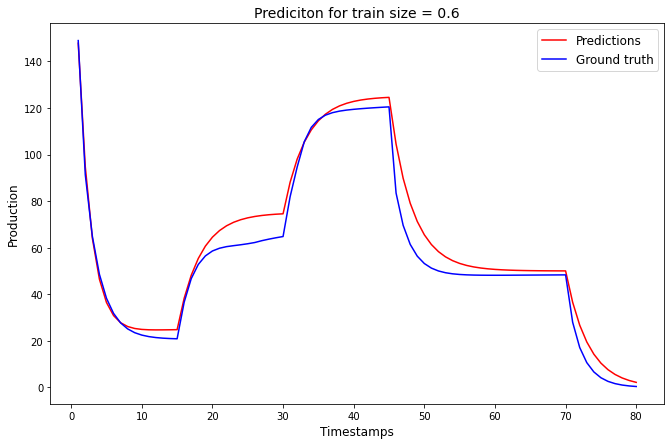

In [156]:
result_1 = scipy.optimize.minimize(obj_func_alt, 
                                   initial_guess_alt, 
                                   args=(train_1, train_1[['P01', 'P02', 'P03', 'P04']].values),
                                   constraints={'type': 'eq', 'fun': lambda x: x.reshape(4, 4)[2, :].sum() - 1},
                                   bounds=b,
                                   method='SLSQP')
print(result_1)

plt.plot(data.index, CRMP_altogether(data, result_1.x)[:, 0], 'r', label='Predictions')
# plt.plot(train_1.index, CRMP_altogether(train_1, result_1.x)[:, 0], 'r', label='Predictions on train')
# plt.plot(test_1.index, CRMP_altogether(test_1, result_1.x)[:, 0], 'g', label='Predictions on test')

plt.plot(data.index, data.P01, 'b', label='Ground truth')

plt.title('Prediciton for train size = 0.6', fontsize=14)
plt.xlabel('Timestamps', fontsize=12)
plt.ylabel('Production', fontsize=12)
plt.legend(fontsize=12);

     fun: 51.731930599715774
     jac: array([-1.68418884e-03, -1.57499313e-03,  4.52613831e-03,  1.98411942e-03,
        7.61985779e-04,  3.05652618e-04,  5.42163849e-04,  5.51223755e-04,
        8.96400524e+02,  8.96433813e+02,  8.96386509e+02,  8.96413352e+02,
        5.96523285e-04, -2.01797485e-03, -7.48157501e-04, -1.16825104e-04])
 message: 'Optimization terminated successfully'
    nfev: 372
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([0.9946743 , 0.99467282, 0.99469612, 0.99468603, 1.8456704 ,
       1.84567099, 1.84563331, 1.84564355, 0.24999986, 0.25000057,
       0.2499994 , 0.25000017, 2.56278888, 2.56279554, 2.56280646,
       2.56279742])


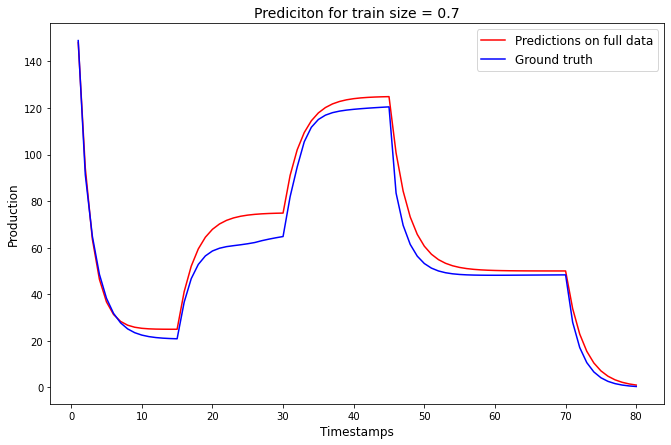

In [158]:
result_2 = scipy.optimize.minimize(obj_func_alt, 
                                   initial_guess_alt, 
                                   args=(train_2, train_2[['P01', 'P02', 'P03', 'P04']].values),
                                   constraints={'type': 'eq', 'fun': lambda x: x.reshape(4, 4)[2, :].sum() - 1},
                                   bounds=b,
                                   method='SLSQP')
print(result_2)

plt.plot(data.index, CRMP_altogether(data, result_2.x)[:, 0], 'r', label='Predictions on full data')
# plt.plot(train_2.index, CRMP_altogether(train_2, result_2.x)[:, 0], 'r', label='Predictions on train')
# plt.plot(test_2.index, CRMP_altogether(test_2, result_2.x)[:, 0], 'g', label='Predictions on test')

plt.plot(data.index, data.P01, 'b', label='Ground truth')

plt.title('Prediciton for train size = 0.7', fontsize=14)
plt.xlabel('Timestamps', fontsize=12)
plt.ylabel('Production', fontsize=12)
plt.legend(fontsize=12);

     fun: 45.80356503155819
     jac: array([-1.23977661e-05, -9.46044922e-04,  8.10623169e-05,  1.61170959e-04,
        2.81333923e-04, -7.34329224e-05, -1.04904175e-04,  7.62939453e-06,
        8.11712280e+02,  8.11715281e+02,  8.11726249e+02,  8.11717025e+02,
        1.07765198e-04,  1.63078308e-04,  6.05583191e-05,  5.81741333e-05])
 message: 'Optimization terminated successfully'
    nfev: 404
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([0.99471476, 0.99471196, 0.99471722, 0.99471675, 1.84402295,
       1.84401049, 1.84399373, 1.84400058, 0.24999988, 0.24999996,
       0.25000019, 0.24999997, 2.55124934, 2.55126115, 2.55126306,
       2.55125393])


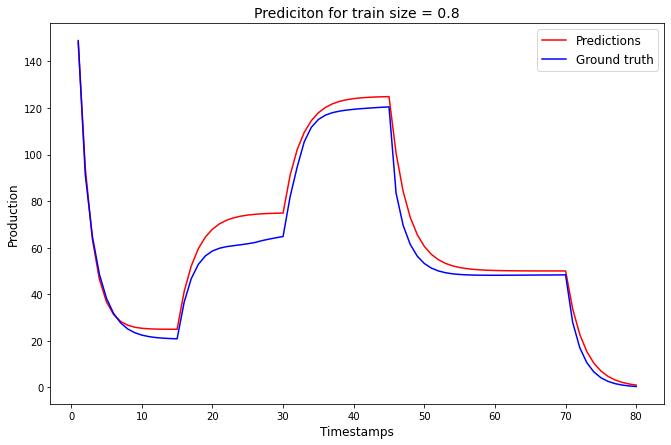

In [159]:
result_3 = scipy.optimize.minimize(obj_func_alt, 
                                   initial_guess_alt, 
                                   args=(train_3, train_3[['P01', 'P02', 'P03', 'P04']].values),
                                   constraints={'type': 'eq', 'fun': lambda x: x.reshape(4, 4)[2, :].sum() - 1},
                                   bounds=b,
                                   method='SLSQP')
print(result_3)

plt.plot(data.index, CRMP_altogether(data, result_3.x)[:, 0], 'r', label='Predictions')
# plt.plot(train_3.index, CRMP_altogether(train_3, result_3.x)[:, 0], 'r', label='Predictions on train')
# plt.plot(test_3.index, CRMP_altogether(test_3, result_3.x)[:, 0], 'g', label='Predictions on test')

plt.plot(data.index, data.P01, 'b', label='Ground truth')

plt.title('Prediciton for train size = 0.8', fontsize=14)
plt.xlabel('Timestamps', fontsize=12)
plt.ylabel('Production', fontsize=12)
plt.legend(fontsize=12);

## Task 2

Calculate metrics (MAE, MSE, R2) on the full dataset and compare the results depending 
on  the  ratio  division  during  optimization  procedure.  Make  sure  that  the  sum  of  defined 
lambda coefficients  for each injector (you have only one in this case)  is equal to one.  If 
not, use constraint optimization.  

In [160]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 

pred_1 = CRMP_altogether(data, result_1.x)[:, 0]
pred_2 = CRMP_altogether(data, result_2.x)[:, 0]
pred_3 = CRMP_altogether(data, result_3.x)[:, 0]
true = data.P01

print(f'For train size 0.6:\n  MSE = {mean_squared_error(true, pred_1)}, MAE = {mean_absolute_error(true, pred_1)}, R^2 = {r2_score(true, pred_1)}')
print(f'For train size 0.7:\n  MSE = {mean_squared_error(true, pred_2)}, MAE = {mean_absolute_error(true, pred_2)}, R^2 = {r2_score(true, pred_2)}')
print(f'For train size 0.8:\n  MSE = {mean_squared_error(true, pred_3)}, MAE = {mean_absolute_error(true, pred_3)}, R^2 = {r2_score(true, pred_3)}')

For train size 0.6:
  MSE = 45.54414417618066, MAE = 5.068241524172797, R^2 = 0.9633630393219328
For train size 0.7:
  MSE = 38.43546286211665, MAE = 4.914529157720095, R^2 = 0.9690814578472386
For train size 0.8:
  MSE = 38.38610930808128, MAE = 4.912031498090099, R^2 = 0.9691211592018524


Suprisingly, there is no real difference in terms of $R^2$ metric for train sizes 0.6 and 0.8. But **MSE** is a bit higher for 0.6 partitioning.

## Task 3

What conclusions can you make about the system analyzing derived parameters? Are there
any impermeable or highly permeable channels in the interwell space?

---

CRM considers the effect of capacitance (compressibility) and resistance (transmissibility), which correspond to two parameters, respectively: The degree of fluid storage ($\tau_j$) and the degree of connectivity ($\lambda_{ij}$) between wells. By considering injection rates as input data and production rates as output, the CRM is derived based on the total fluid mass balance in the control volume.[1]

I would say, that we have pretty isotropic media since transsmisibility from the injection well to all the production wells are the same.

---

1.Salehian, Mohammad, and Murat Çınar. "Reservoir characterization using dynamic capacitance–resistance model with application to shut-in and horizontal wells." Journal of Petroleum Exploration and Production Technology 9.4 (2019): 2811-2830.